# Experiment on Binary AlphaDigit

In [2]:
# Import.
import os

import numpy as np
import matplotlib.pyplot as plt

from models.rbm import RBM
from utils import (
    load_alphadigit,
    read_alpha_digit,
    plot_characters_alphadigit,
    plot_generated_images
)

In [3]:
DATA_FOLDER = "../data/"
RESULTS_FOLDER = "../results/"
WEIGHTS_FOLDER = os.path.join(RESULTS_FOLDER, "weights")
ALPHA_DIGIT_PATH = os.path.join(DATA_FOLDER, "binaryalphadigs.mat")

for path in [ALPHA_DIGIT_PATH, WEIGHTS_FOLDER]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"The file {path} does not exist.")

SEED = 42

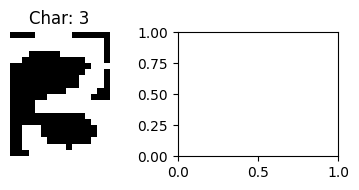

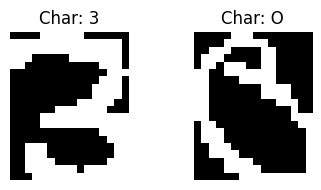

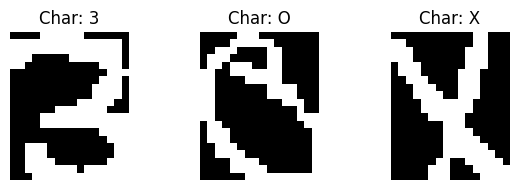

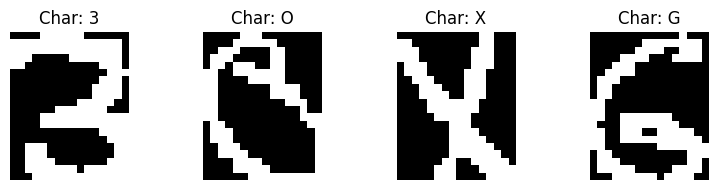

Original data: (36, 39)
Original data (unstack samples -> flatten images): (1365, 320)
Subset (39 characters) data  (39, 320)
Subset (78 characters) data  (78, 320)
Subset (117 characters) data  (117, 320)
Subset (156 characters) data  (156, 320)


In [4]:
alphadigit = load_alphadigit(ALPHA_DIGIT_PATH)

chars_1 = [3]
chars_2 = chars_1 + ["O"]
chars_3 = chars_2 + ["X"]
chars_4 = chars_3 + ["G"]
chars_list = [chars_1, chars_2, chars_3, chars_4]
data_alphas = [
    read_alpha_digit(chars, data=alphadigit, use_data=True) 
    for chars in [chars_1, chars_2, chars_3, chars_4]
]

all_chars = np.arange(0, 35).tolist()
alphadigit_data = read_alpha_digit(all_chars, data=alphadigit, use_data=True) # read all characters

for chars, data_alpha in zip(chars_list, data_alphas):
    plot_characters_alphadigit(chars, data_alpha)

print("Original data:", alphadigit.shape)
print("Original data (unstack samples -> flatten images):", alphadigit_data.shape)
for i, data_alpha in enumerate(data_alphas):
    print(f"Subset ({len(data_alpha)} characters) data ", data_alpha.shape)

## 2. Testing RBM

In [ ]:
data_alpha = data_alphas[2]
n_chars = data_alpha.shape[0] / 39

# Parameters
n_visible = data_alpha.shape[1]  # Number of visible units (size of each image)
n_hidden = 256  # Number of hidden units (hyperparameter)
learning_rate = 1e-3
n_epochs = 5000
batch_size = 32
# batch_size = int(8 * n_chars)

RBM(n_visible=320, n_hidden=256)
Epoch 0. Reconstruction error:  0.2011.
Epoch 500. Reconstruction error:  0.0064.
Epoch 1000. Reconstruction error:  0.0016.
Epoch 1500. Reconstruction error:  0.0007.
Epoch 2000. Reconstruction error:  0.0003.
Epoch 2500. Reconstruction error:  0.0002.
Epoch 3000. Reconstruction error:  0.0001.
Epoch 3500. Reconstruction error:  0.0001.
Epoch 4000. Reconstruction error:  0.0001.
Epoch 4500. Reconstruction error:  0.0001.
Epoch 4999. Reconstruction error:  0.0000.


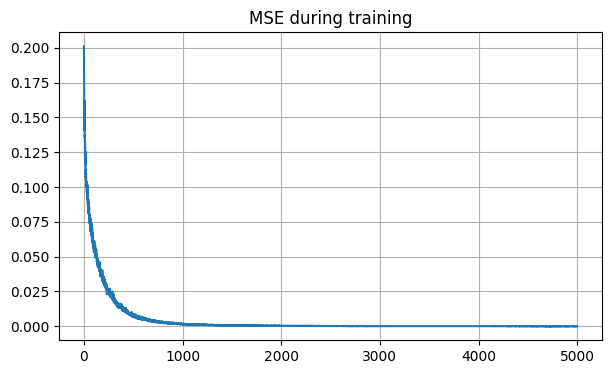

In [5]:
# 1min 5s

# Initialize RBM
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, random_state=SEED)
print(rbm)

# Train RBM
errors_rbm = rbm.train(
    input_data=data_alpha, learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size,
    plot_errors=True, verbose=True
)

In [6]:
# Generate samples
generated_samples = rbm.generate_image(n_samples=20, n_gibbs_steps=2000)

100%|██████████| 2000/2000 [00:00<00:00, 2503.12it/s]


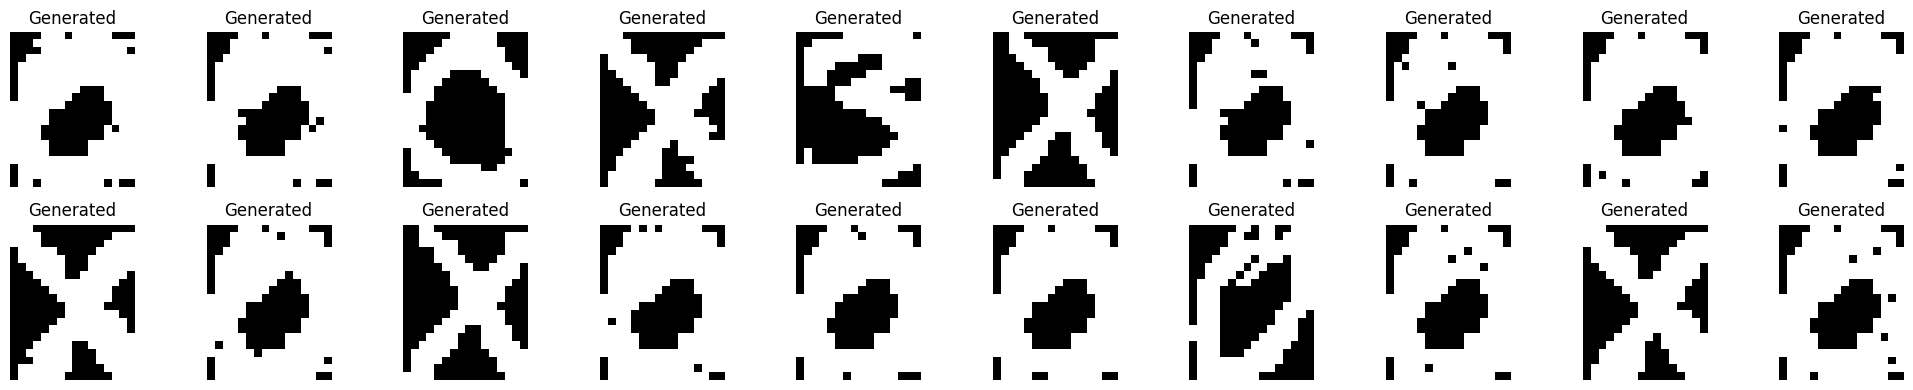

In [7]:
plot_generated_images(generated_samples)

## 3. Experiments RBM

In [8]:
def train_rbm(characters=None, n_hidden=256, data=None, training_args=None, n_samples=10):
    
    # Load data.
    if data is None:
        data = load_alphadigit(ALPHA_DIGIT_PATH)
    data_alpha = read_alpha_digit(characters, data=data, use_data=True)

    # Train RBM.
    print("Training RBM...")
    n_visible = data_alpha.shape[1]
    rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, random_state=SEED)
    errors_rbm = rbm.train(input_data=data_alpha, **training_args)

    # Generate samples.
    print("Generating samples...")
    generated_samples = rbm.generate_image(n_samples=n_samples, n_gibbs_steps=2000)

    return rbm, errors_rbm, generated_samples 

In [9]:
training_args = {
    "learning_rate": 1e-3,
    "n_epochs": 3000,
    "batch_size": 32,
    "plot_errors": False,
    "verbose": False
}
# train_rbm(["A"], training_args=training_args)

### Varying the Number of Hidden Units.

In [10]:
# 1min 30s
def experiment_number_hidden_units(
        chars,
        n_hidden_list,
        training_args=training_args,
    ):
    models_dict = {}
    errors_dict = {}
    gen_images_dict = {}

    for n_hidden in n_hidden_list:
        print(f"Number of hidden units : {n_hidden}")
        # Train the RBM
        model, errors, generated_images = train_rbm(
            chars, n_hidden=n_hidden, training_args=training_args
        )

        # Store the trained model and errors
        models_dict[n_hidden] = model
        errors_dict[n_hidden] = errors
        gen_images_dict[n_hidden] = generated_images

    return models_dict, errors_dict, gen_images_dict

models_dict, errors_dict, images_dict = experiment_number_hidden_units(
    chars=["A"], n_hidden_list=[10, 50, 100, 200, 500]
)

100%|██████████| 2000/2000 [00:00<00:00, 2019.95it/s]


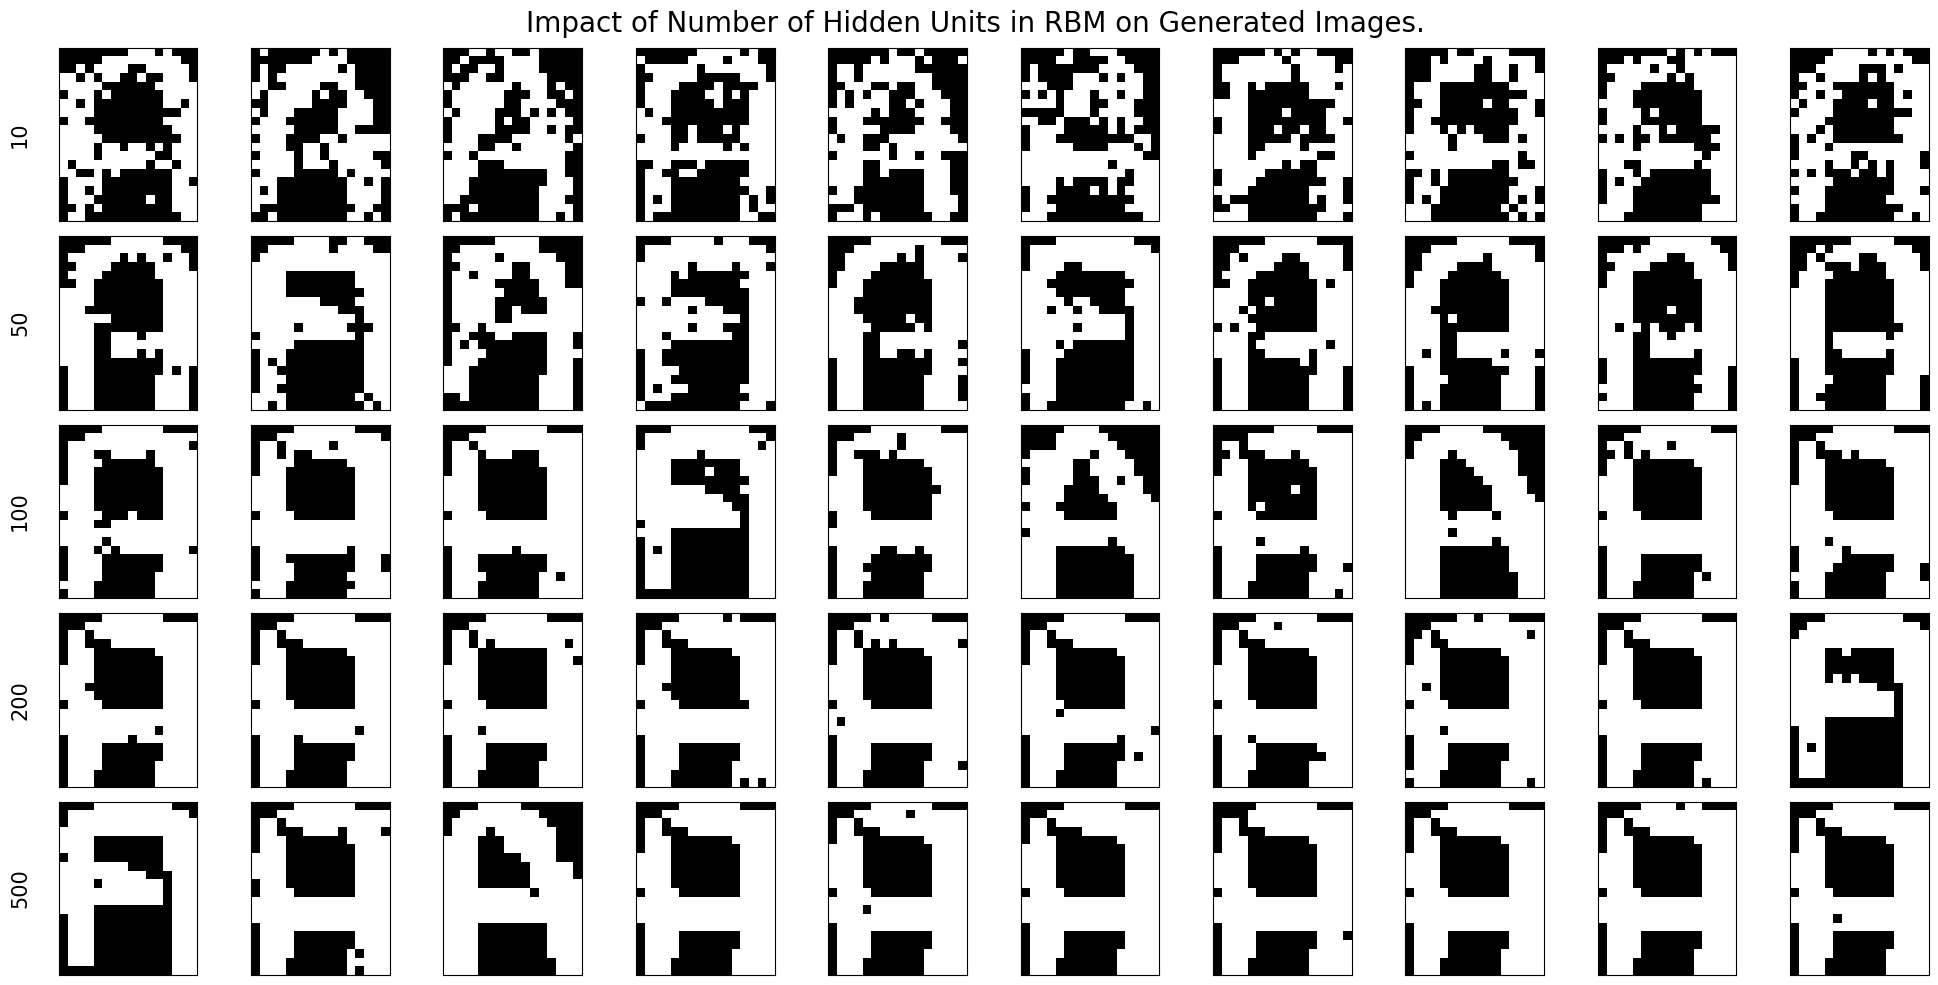

In [11]:
def plot_images(images_dict, n_samples, reshape, title=None):
    fig, axs = plt.subplots(len(images_dict), n_samples, figsize=(20, len(images_dict)*2)) 

    plt.suptitle(title, fontsize=20)
    for i, (ylabel, images) in enumerate(images_dict.items()):
        for j in range(n_samples): 
            ax = axs[i, j] 
            ax.imshow(images[j].reshape(*reshape), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            if j == 0:
                ax.set_ylabel(f'{ylabel}\n', fontsize=15)
    
    plt.tight_layout()
    plt.show()

plot_images(
    images_dict, n_samples=10, reshape=(20, 16), 
    title="Impact of Number of Hidden Units in RBM on Generated Images."
)

### Varying the Number of Characters in the Data.

In [12]:
def random_subset_alphadigit(n_chars=10, data=None, use_data=False, random_state=SEED):
    rng = np.random.default_rng(random_state)
    random_chars = np.random.choice(list(range(35)), n_chars, replace=False).tolist()
    data = read_alpha_digit(random_chars, data=alphadigit, use_data=True)
    return random_chars, data

chars, data = random_subset_alphadigit(10, data=alphadigit, use_data=True)
print(chars, data.shape)
assert len(chars) == data.shape[0] / 39

[26, 33, 6, 3, 13, 2, 28, 15, 8, 12] (390, 320)


In [15]:
# [1, 2, 4, 8, 16, 24]
def experiment_number_characters(
        n_chars_list,
        n_hidden=100,
        training_args=training_args,
    ):
    models_dict = {}
    errors_dict = {}
    gen_images_dict = {}

    for n_chars in n_chars_list:
        print(f"Number of characters : {n_chars}")
        # Load data.
        chars, data = random_subset_alphadigit(n_chars, data=alphadigit, use_data=True)

        # Train the RBM.
        model, errors, generated_images = train_rbm(
            chars, n_hidden=n_hidden, data=data, training_args=training_args
        )

        # Store the trained model and errors.
        models_dict[n_chars] = model
        errors_dict[n_chars] = errors
        gen_images_dict[n_chars] = generated_images

    return models_dict, errors_dict, gen_images_dict

models_dict, errors_dict, images_dict = experiment_number_characters(
    n_chars_list=[1, 2, 4, 8, 16, 24]
)

100%|██████████| 2000/2000 [00:00<00:00, 15151.74it/s]
